In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.linear_model import LogisticRegression, Ridge, SGDRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, TimeSeriesSplit
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, mean_absolute_error, make_scorer
import lightgbm as lgb
import xgboost as xgb
import catboost

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/liverpool-ion-switching/train.csv
/kaggle/input/liverpool-ion-switching/test.csv
/kaggle/input/liverpool-ion-switching/sample_submission.csv


In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        if col != 'time':
            col_type = df[col].dtypes
            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


In [3]:
train = reduce_mem_usage(pd.read_csv('/kaggle/input/liverpool-ion-switching/train.csv'))
test = reduce_mem_usage(pd.read_csv('/kaggle/input/liverpool-ion-switching/test.csv'))

Mem. usage decreased to 52.45 Mb (54.2% reduction)
Mem. usage decreased to 19.07 Mb (37.5% reduction)


<h3> Remove drift

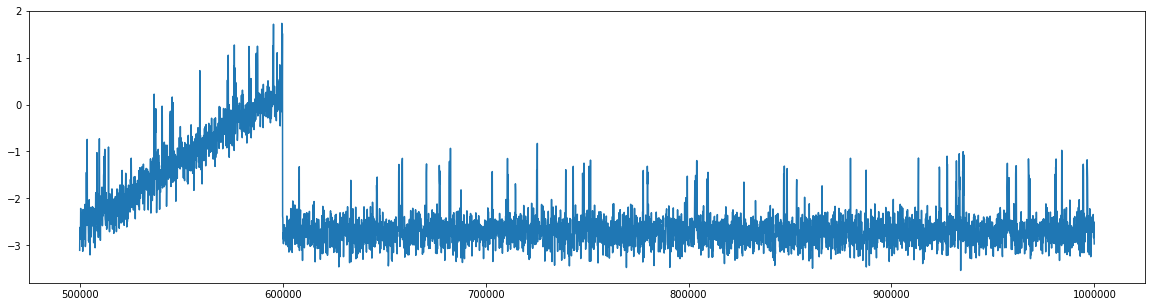

In [4]:
plt.figure(figsize=(20,5))
plt.plot( train.signal[500000:1000000][::100] )
plt.show()

In [5]:
a = 500000; b = a * 2
print( 'Before: mean: {} std: {} median: {}'.format( train.signal[a:b].mean(), train.signal[a:b].std(),train.signal[a:b].median() ) )

a=500000; b=600000
train['signal_undrifted'] = train.signal
train.loc[train.index[a:b],'signal_undrifted'] = train.signal[a:b].values - 3*(train.time.values[a:b] - 50)/10.

a = 500000; b = a *2
print( 'After: mean: {} std: {} median: {}'.format( train.signal_undrifted[a:b].mean(), train.signal_undrifted[a:b].std(),train.signal_undrifted[a:b].median() ) )


Before: mean: nan std: 0.0 median: -2.6484375
After: mean: nan std: 0.0 median: -2.71484375


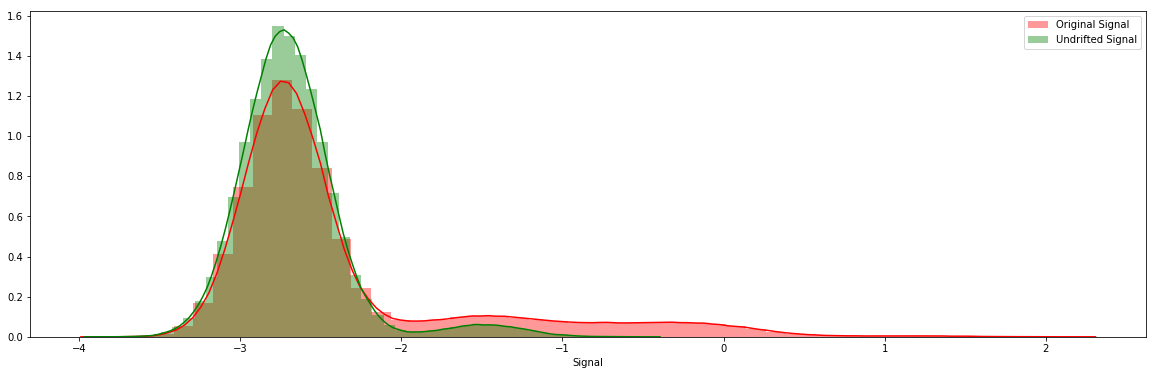

In [6]:
plt.figure(figsize=(20,6))
sns.distplot(train.signal[500000:1000000],color='r')
sns.distplot(train.signal_undrifted[500000:1000000],color='g' ).set(xlabel="Signal")
plt.legend(labels=['Original Signal','Undrifted Signal'])

In [7]:
def f(x,low,high,mid): return -((-low+high)/625)*(x-mid)**2+high -low

# CLEAN TRAIN BATCH 7
batch = 7; a = 500000*(batch-1); b = 500000*batch
train.loc[train.index[a:b],'signal_undrifted'] = train.signal.values[a:b] - f(train.time[a:b].values,-1.817,3.186,325)
# CLEAN TRAIN BATCH 8
batch = 8; a = 500000*(batch-1); b = 500000*batch
train.loc[train.index[a:b],'signal_undrifted'] = train.signal.values[a:b] - f(train.time[a:b].values,-0.094,4.936,375)
# CLEAN TRAIN BATCH 9
batch = 9; a = 500000*(batch-1); b = 500000*batch
train.loc[train.index[a:b],'signal_undrifted'] = train.signal.values[a:b] - f(train.time[a:b].values,1.715,6.689,425)
# CLEAN TRAIN BATCH 10
batch = 10; a = 500000*(batch-1); b = 500000*batch
train.loc[train.index[a:b],'signal_undrifted'] = train.signal.values[a:b] - f(train.time[a:b].values,3.361,8.45,475)

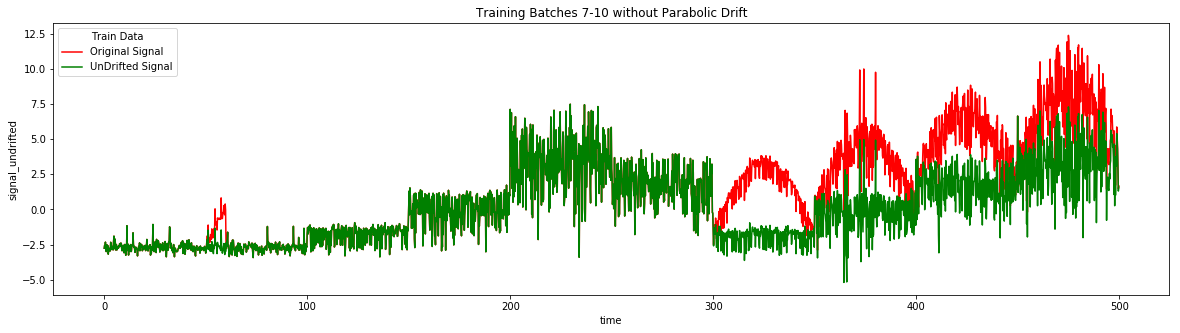

In [8]:
plt.figure(figsize=(20,5))
sns.lineplot(train.time[::1000],train.signal[::2000],color='r').set_title('Training Batches 7-10 with Parabolic Drift')
#plt.figure(figsize=(20,5))
g = sns.lineplot(train.time[::1000],train.signal_undrifted[::2000],color='g').set_title('Training Batches 7-10 without Parabolic Drift')
plt.legend(title='Train Data',loc='upper left', labels=['Original Signal', 'UnDrifted Signal'])
plt.show(g)

In [9]:
test['signal_undrifted'] = test.signal

# REMOVE BATCH 1 DRIFT
start=500
a = 0; b = 100000
test.loc[test.index[a:b],'signal_undrifted'] = test.signal.values[a:b] - 3*(test.time.values[a:b]-start)/10.
start=510
a = 100000; b = 200000
test.loc[test.index[a:b],'signal_undrifted'] = test.signal.values[a:b] - 3*(test.time.values[a:b]-start)/10.
start=540
a = 400000; b = 500000
test.loc[test.index[a:b],'signal_undrifted'] = test.signal.values[a:b] - 3*(test.time.values[a:b]-start)/10.

# REMOVE BATCH 2 DRIFT
start=560
a = 600000; b = 700000
test.loc[test.index[a:b],'signal_undrifted'] = test.signal.values[a:b] - 3*(test.time.values[a:b]-start)/10.
start=570
a = 700000; b = 800000
test.loc[test.index[a:b],'signal_undrifted'] = test.signal.values[a:b] - 3*(test.time.values[a:b]-start)/10.
start=580
a = 800000; b = 900000
test.loc[test.index[a:b],'signal_undrifted'] = test.signal.values[a:b] - 3*(test.time.values[a:b]-start)/10.

# REMOVE BATCH 3 DRIFT
def f(x):
    return -(0.00788)*(x-625)**2+2.345 +2.58
a = 1000000; b = 1500000
test.loc[test.index[a:b],'signal_undrifted'] = test.signal.values[a:b] - f(test.time[a:b].values)

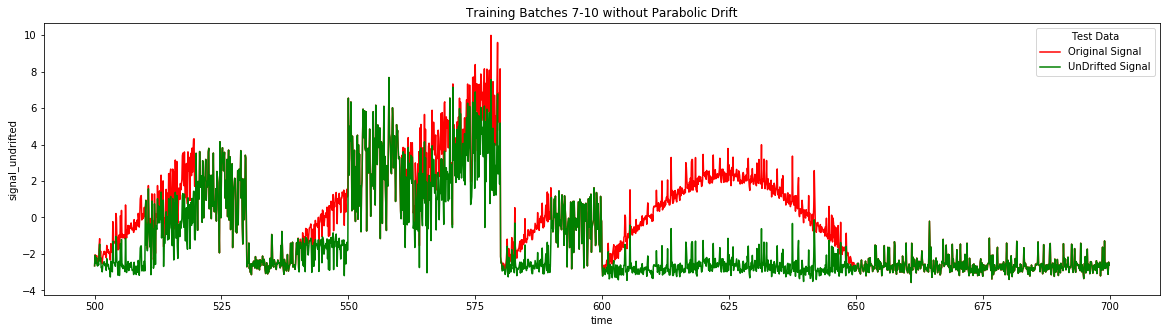

In [10]:
plt.figure(figsize=(20,5))
sns.lineplot(test.time[::1000],test.signal[::1000],color='r').set_title('Training Batches 7-10 with Parabolic Drift')
#plt.figure(figsize=(20,5))
g = sns.lineplot(test.time[::1000],test.signal_undrifted[::1000],color='g').set_title('Training Batches 7-10 without Parabolic Drift')
plt.legend(title='Test Data',loc='upper right', labels=['Original Signal', 'UnDrifted Signal'])
plt.show(g)

<h3> Feature Engineering

In [11]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)


Mem. usage decreased to 61.99 Mb (0.0% reduction)
Mem. usage decreased to 22.89 Mb (0.0% reduction)


In [12]:
%%time

def features(df):
    df = df.sort_values(by=['time']).reset_index(drop=True)
    df.index = ((df.time * 10_000) - 1).values
    df['batch'] = df.index // 50_000
    df['batch_index'] = df.index  - (df.batch * 50_000)
    df['batch_slices'] = df['batch_index']  // 5_000
    df['batch_slices2'] = df.apply(lambda r: '_'.join([str(r['batch']).zfill(3), str(r['batch_slices']).zfill(3)]), axis=1)
    
    for c in ['batch','batch_slices2']:
        d = {}
        d['mean'+c] = df.groupby([c])['signal_undrifted'].mean()
        d['median'+c] = df.groupby([c])['signal_undrifted'].median()
        d['max'+c] = df.groupby([c])['signal_undrifted'].max()
        d['min'+c] = df.groupby([c])['signal_undrifted'].min()
        d['std'+c] = df.groupby([c])['signal_undrifted'].std()
        d['mean_abs_chg'+c] = df.groupby([c])['signal_undrifted'].apply(lambda x: np.mean(np.abs(np.diff(x))))
        d['abs_max'+c] = df.groupby([c])['signal_undrifted'].apply(lambda x: np.max(np.abs(x)))
        d['abs_min'+c] = df.groupby([c])['signal_undrifted'].apply(lambda x: np.min(np.abs(x)))
        for v in d:
            df[v] = df[c].map(d[v].to_dict())
        df['range'+c] = df['max'+c] - df['min'+c]
        df['maxtomin'+c] = df['max'+c] / df['min'+c]
        df['abs_avg'+c] = (df['abs_min'+c] + df['abs_max'+c]) / 2
    
    #add shifts
    df['signal_shift_+1'] = [0,] + list(df['signal_undrifted'].values[:-1])
    df['signal_shift_-1'] = list(df['signal_undrifted'].values[1:]) + [0]
    for i in df[df['batch_index']==0].index:
        df['signal_shift_+1'][i] = np.nan
    for i in df[df['batch_index']==49999].index:
        df['signal_shift_-1'][i] = np.nan

    for c in [c1 for c1 in df.columns if c1 not in ['time', 'signal_undrifted', 'open_channels', 'batch', 'batch_index', 'batch_slices', 'batch_slices2']]:
        df[c+'_msignal'] = df[c] - df['signal_undrifted']
        
    return df

train = features(train)
test = features(test)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning:


A value is trying 

CPU times: user 5min 27s, sys: 5.59 s, total: 5min 33s
Wall time: 5min 33s


In [13]:
test.shape

(2000000, 56)

<h3> Statistical features

In [14]:
# window_sizes = [10, 50]

# for window in window_sizes:
#     train['rolling_mean_' + str(window)] = train['signal'].rolling(window = window).mean()
#     train["rolling_std_" + str(window)] = train['signal'].rolling(window=window).std()
#     train["rolling_var_" + str(window)] = train['signal'].rolling(window=window).var()
#     train["rolling_min_" + str(window)] = train['signal'].rolling(window=window).min()
#     train["rolling_max_" + str(window)] = train['signal'].rolling(window=window).max()
    
#     train["rolling_min_max_ratio_" + str(window)] = train["rolling_min_" + str(window)] / train["rolling_max_" + str(window)]
#     train["rolling_min_max_diff_" + str(window)] = train["rolling_max_" + str(window)] - train["rolling_min_" + str(window)]
#     a = (train['signal'] - train['rolling_min_' + str(window)]) / (train['rolling_max_' + str(window)] - train['rolling_min_' + str(window)])
#     train["norm_" + str(window)] = a * (np.floor(train['rolling_max_' + str(window)]) - np.ceil(train['rolling_min_' + str(window)]))
# train = train.replace([np.inf, -np.inf], np.nan)   
# train.fillna(0, inplace = True)
# train_y = train['open_channels']
# train_x = train.drop(columns = ['time', 'open_channels'])

In [15]:
# scaler = StandardScaler()
# scaler.fit(train_x)
# train_x_scaled = pd.DataFrame(scaler.transform(train_x), columns = train_x.columns)

In [16]:
# train_x_scaled = reduce_mem_usage(train_x_scaled)

In [17]:
# test.drop(columns = ['time'], inplace = True)
# test.shape

In [18]:
# for window in window_sizes:
#     test['rolling_mean_' + str(window)] = test['signal'].rolling(window = window).mean()
#     test["rolling_std_" + str(window)] = test['signal'].rolling(window=window).std()
#     test["rolling_var_" + str(window)] = test['signal'].rolling(window=window).var()
#     test["rolling_min_" + str(window)] = test['signal'].rolling(window=window).min()
#     test["rolling_max_" + str(window)] = test['signal'].rolling(window=window).max()
    
#     test["rolling_min_max_ratio_" + str(window)] = test["rolling_min_" + str(window)] / test["rolling_max_" + str(window)]
#     test["rolling_min_max_diff_" + str(window)] = test["rolling_max_" + str(window)] - test["rolling_min_" + str(window)]
#     a = (test['signal'] - test['rolling_min_' + str(window)]) / (test['rolling_max_' + str(window)] - test['rolling_min_' + str(window)])
#     test["norm_" + str(window)] = a * (np.floor(test['rolling_max_' + str(window)]) - np.ceil(test['rolling_min_' + str(window)]))
# test = test.replace([np.inf, -np.inf], np.nan)   
# test.fillna(0, inplace = True)

In [19]:
# test_x_scaled = pd.DataFrame(scaler.transform(test), columns = test.columns)

In [20]:
# test_x_scaled = reduce_mem_usage(test_x_scaled)

<h3> Model

In [21]:
def f1_score_calc(y_true, y_pred):
    return f1_score(y_true, y_pred, average="macro")

def lgb_Metric(preds, dtrain):
    labels = dtrain.get_label()
    preds = np.round(np.clip(preds, 0, 10)).astype(int)
    score = f1_score(labels, preds, average="macro")
    return ('KaggleMetric', score, True)


def train_model_classification(X, X_test, y, params, model_type='lgb', eval_metric='f1score',
                               columns=None, plot_feature_importance=False, model=None,
                               verbose=50, early_stopping_rounds=200, n_estimators=2000):

    columns = X.columns if columns == None else columns
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {
                    'f1score': {'lgb_metric_name': lgb_Metric,}
                   }
    
    result_dict = {}
    
    # out-of-fold predictions on train data
    oof = np.zeros(len(X))
    
    # averaged predictions on train data
    prediction = np.zeros((len(X_test)))
    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    '''for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]'''
            
    if True:        
        X_train, X_valid, y_train, y_valid =  train_test_split(X, y, test_size=0.3, random_state=7)    
            
        if model_type == 'lgb':
            #model = lgb.LGBMClassifier(**params, n_estimators=n_estimators)
            #model.fit(X_train, y_train, 
            #        eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
            #       verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            model = lgb.train(params, lgb.Dataset(X_train, y_train),
                              n_estimators,  lgb.Dataset(X_valid, y_valid),
                              verbose_eval=verbose, early_stopping_rounds=early_stopping_rounds, feval=lgb_Metric)
            
            
            preds = model.predict(X, num_iteration=model.best_iteration) #model.predict(X_valid) 

            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            
        if model_type == 'xgb':
            train_set = xgb.DMatrix(X_train, y_train)
            val_set = xgb.DMatrix(X_valid, y_valid)
            model = xgb.train(params, train_set, num_boost_round=2222, evals=[(train_set, 'train'), (val_set, 'val')], 
                                     verbose_eval=verbose, early_stopping_rounds=early_stopping_rounds)
            
            preds = model.predict(xgb.DMatrix(X)) 

            y_pred = model.predict(xgb.DMatrix(X_test))
            

        if model_type == 'cat':
            # Initialize CatBoostRegressor
            model = CatBoostRegressor(params)
            # Fit model
            model.fit(X_train, y_train)
            # Get predictions
            y_pred_valid = np.round(np.clip(preds, 0, 10)).astype(int)

            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            y_pred = np.round(np.clip(y_pred, 0, 10)).astype(int)

 
        oof = preds
        
        scores.append(f1_score_calc(y, np.round(np.clip(preds,0,10)).astype(int) ) )

        prediction += y_pred    
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    #prediction /= folds.n_splits
    
    print('FINAL score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    result_dict['model'] = model
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= folds.n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
        
    return result_dict

In [22]:
cols_to_use = [c for c in train.columns if c not in ['time', 'signal', 'open_channels', 'batch', 'batch_index', 'batch_slices', 'batch_slices2']]

X = train[cols_to_use].copy()
y = train['open_channels']
X_test = test[cols_to_use].copy()

In [23]:
del train, test

In [24]:
params_xgb = {'colsample_bytree': 0.375,'learning_rate': 0.1,'max_depth': 10, 'subsample': 1, 'objective':'reg:squarederror',
          'eval_metric':'rmse'}

result_dict_xgb = train_model_classification(X=X[0:500000*8-1], X_test=X_test, y=y[0:500000*8-1], params=params_xgb, model_type='xgb', eval_metric='f1score', plot_feature_importance=False,
                                                      verbose=50, early_stopping_rounds=250)

[0]	train-rmse:2.55394	val-rmse:2.55558
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 250 rounds.
[50]	train-rmse:0.12981	val-rmse:0.13853
[100]	train-rmse:0.12615	val-rmse:0.13775
[150]	train-rmse:0.12482	val-rmse:0.13775
[200]	train-rmse:0.12360	val-rmse:0.13782
[250]	train-rmse:0.12277	val-rmse:0.13791
[300]	train-rmse:0.12164	val-rmse:0.13797
[350]	train-rmse:0.12049	val-rmse:0.13805
Stopping. Best iteration:
[148]	train-rmse:0.12484	val-rmse:0.13775

FINAL score: 0.9475, std: 0.0000.


In [25]:
params_lgb = {'learning_rate': 0.01, 'max_depth': -1, 'num_leaves':200, 'metric': 'rmse', 'random_state': 42, 'n_jobs':-1}

result_dict_lgb = train_model_classification(X=X[0:500000*8-1], X_test=X_test, y=y[0:500000*8-1], params=params_lgb, model_type='lgb', eval_metric='f1score', plot_feature_importance=False,
                                                      verbose=50, early_stopping_rounds=250, n_estimators=3000)

Training until validation scores don't improve for 250 rounds
[50]	valid_0's rmse: 1.43289	valid_0's KaggleMetric: 0.038008
[100]	valid_0's rmse: 0.87416	valid_0's KaggleMetric: 0.221033
[150]	valid_0's rmse: 0.540454	valid_0's KaggleMetric: 0.438831
[200]	valid_0's rmse: 0.345184	valid_0's KaggleMetric: 0.564764
[250]	valid_0's rmse: 0.236117	valid_0's KaggleMetric: 0.7474
[300]	valid_0's rmse: 0.180268	valid_0's KaggleMetric: 0.919037
[350]	valid_0's rmse: 0.154807	valid_0's KaggleMetric: 0.932026
[400]	valid_0's rmse: 0.144292	valid_0's KaggleMetric: 0.935185
[450]	valid_0's rmse: 0.140202	valid_0's KaggleMetric: 0.936373
[500]	valid_0's rmse: 0.13863	valid_0's KaggleMetric: 0.936967
[550]	valid_0's rmse: 0.137985	valid_0's KaggleMetric: 0.937218
[600]	valid_0's rmse: 0.137709	valid_0's KaggleMetric: 0.937395
[650]	valid_0's rmse: 0.137601	valid_0's KaggleMetric: 0.937389
[700]	valid_0's rmse: 0.137547	valid_0's KaggleMetric: 0.937376
[750]	valid_0's rmse: 0.137507	valid_0's KaggleM

In [26]:
result_dict_lgb

{'oof': array([-8.56497855e-03,  3.04886875e-04,  1.28640362e-04, ...,
         2.04685133e+00,  1.03009470e+00,  2.00976252e+00]),
 'prediction': array([0.01137296, 0.00030929, 0.00030489, ..., 0.00030489, 0.00030489,
        0.01627551]),
 'scores': [0.9391372453129321],
 'model': <lightgbm.basic.Booster at 0x7fea3672da58>}

In [27]:
preds_ensemble = 0.30 * result_dict_lgb['prediction'] + 0.70 * result_dict_xgb['prediction']

In [28]:
sub = pd.read_csv('/kaggle/input/liverpool-ion-switching/sample_submission.csv')
sub['open_channels'] =  np.array(np.round(preds_ensemble,0), np.int) 

In [29]:
sub.to_csv('submission_unshifted_2.csv', index=False, float_format='%.4f')
sub.head(10)

,time,open_channels
0,500.0001,0
1,500.0002,0
2,500.0003,0
3,500.0004,0
4,500.0005,0
5,500.0006,0
6,500.0007,0
7,500.0008,0
8,500.0009,0
9,500.0010,0


In [30]:
# FE-2 (window_sizes = window_sizes = [10, 50] with new features: signalshift+2, signalshift-2) & FE-3 = 84 features
seed_random = 42
lr_lgb = 0.01
num_leaves = 200
num_iterations = 2000
w_lgb = 1

In [31]:
X = train_x_scaled
y = train_y
test = test_x_scaled

NameError: name 'train_x_scaled' is not defined

In [32]:
x1, x2, y1, y2 = train_test_split(X, y, test_size=0.3, random_state=7)
params = {'learning_rate': lr_lgb, 
          'max_depth': -1, 
          'num_leaves': num_leaves,
          'metric': 'logloss', 
          'random_state': seed_random, 
          'n_jobs':-1, 
          'sample_fraction':0.33}


In [33]:
# f1_score(train_y, y_pred_train_lgb, average='macro')


In [34]:
def MacroF1Metric(preds, dtrain):
    labels = dtrain.get_label()
    preds = np.round(np.clip(preds, 0, 10)).astype(int)
    score = f1_score(labels, preds, average = 'macro')
    return ('MacroF1Metric', score, True)

In [35]:
model = lgb.train(params, lgb.Dataset(x1, y1), 500,  lgb.Dataset(x2, y2), verbose_eval=0, early_stopping_rounds=250, feval=MacroF1Metric)
preds_lgb = (model.predict(test, num_iteration=model.best_iteration)).astype(np.float16)
# oof_lgb = (model.predict(X, num_iteration=model.best_iteration)).astype(np.float16)

NameError: name 'test' is not defined

In [36]:
submission = pd.read_csv('/kaggle/input/liverpool-ion-switching/test.csv')

In [37]:
submission['open_channels'] = np.round(np.clip(preds_lgb, 0, 10)).astype(int)

NameError: name 'preds_lgb' is not defined

In [38]:
submission[['time','open_channels']].to_csv('submission_1.csv', index=False, float_format='%.4f')

KeyError: "['open_channels'] not in index"

In [39]:
# from catboost import Pool,CatBoostRegressor
# model = CatBoostRegressor(iterations=1000, learning_rate=0.1, random_seed = 7, depth=7, eval_metric='RMSE')
# train_dataset = Pool(x1,  y1)          
# eval_dataset = Pool(x2,  y2)
# model.fit(train_dataset, eval_set=eval_dataset, verbose=0, early_stopping_rounds=250)
# preds_cb = (model.predict(test)).astype(np.float16)
# #oof_cb = (model.predict(X)).astype(np.float16)